In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.preprocessing import sequence


C:\Users\Dario\AppData\Local\Temp\ipykernel_23180\4147300727.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ev = pd.read_csv('ia_data_events.csv')


array([[<Axes: title={'center': 'state'}>,
        <Axes: title={'center': 'isMoving'}>],
       [<Axes: title={'center': 'isPumpOn'}>,
        <Axes: title={'center': 'pressure'}>]], dtype=object)

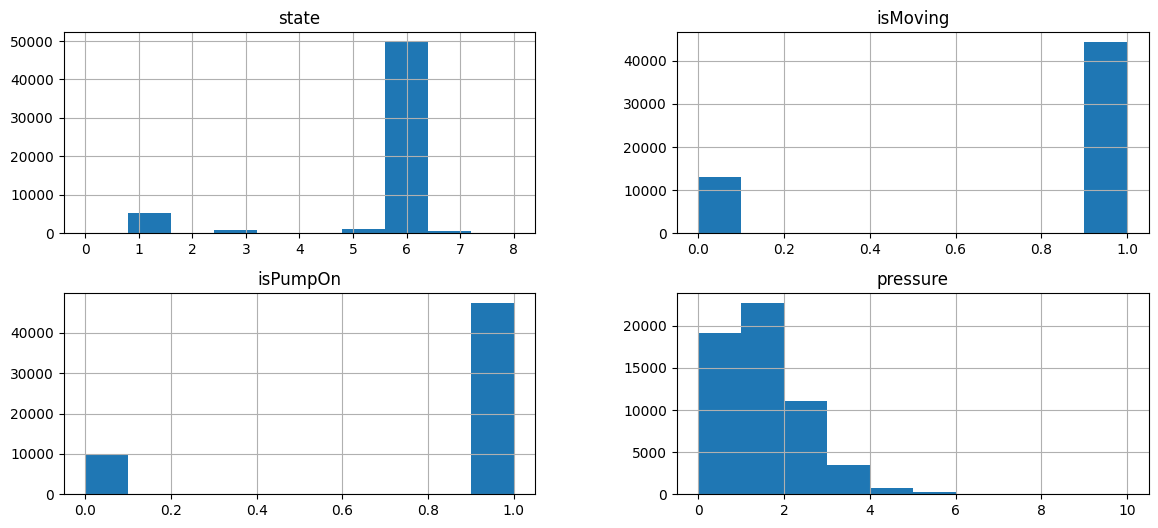

In [97]:
df_ev = pd.read_csv('ia_data_events.csv')
df_ev['isMoving'] = df_ev['isMoving'].astype(int)
df_ev['isPumpOn'] = df_ev['isPumpOn'].astype(int)
df_ev.hist(column=['state', 'isMoving', 'isPumpOn', 'pressure'], figsize=(14, 6))


array([[<Axes: title={'center': 'state'}>,
        <Axes: title={'center': 'isMoving'}>],
       [<Axes: title={'center': 'isPumpOn'}>,
        <Axes: title={'center': 'pressure'}>]], dtype=object)

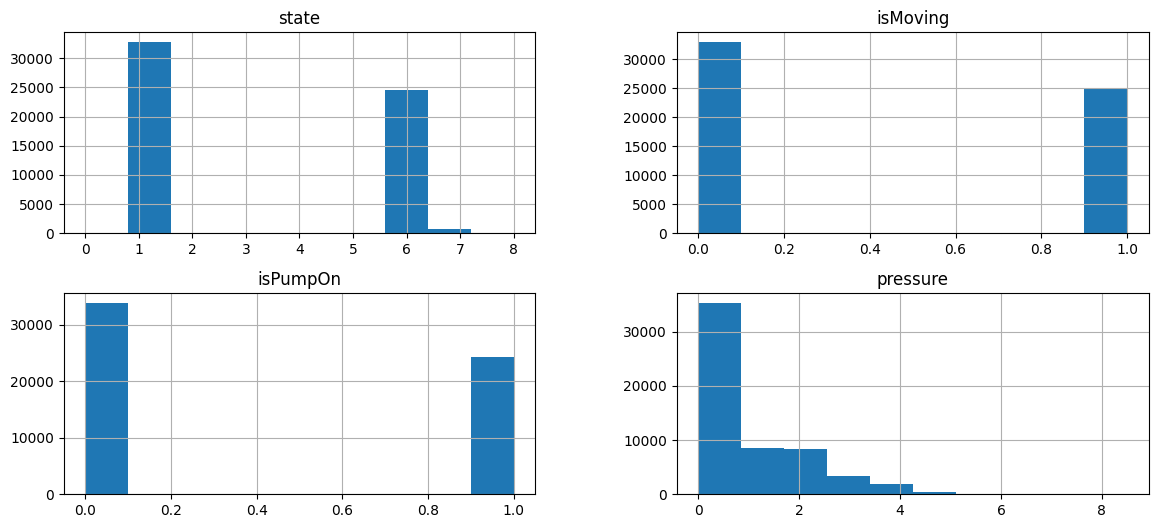

In [98]:
df_nf = pd.read_csv('ia_data_no_fails.csv')
df_nf['isMoving'] = df_nf['isMoving'].astype(int)
df_nf['isPumpOn'] = df_nf['isPumpOn'].astype(int)
df_nf.hist(column=['state', 'isMoving', 'isPumpOn', 'pressure'], figsize=(14, 6))

In [99]:
devices_data = pd.read_csv('devices_data.csv')
df_ev = df_ev.merge(devices_data, on='deviceId')
df_nf = df_nf.merge(devices_data, on='deviceId')

# Only keeps rows of type 1 (pivot)
df_ev = df_ev[df_ev['Tipo'] == 1]
df_nf = df_nf[df_nf['Tipo'] == 1]

df_ev.describe()

,angle,distanceSpeed,flow,isMoving,isPumpOn,latitude,longitude,messageId,pressure,rawSpeed,speed,state,timeToFail,intervalGroup,Area,Largo,Tipo,Caudal,Presion
count,24442.000000,24442.000000,24442.000000,24442.000000,24442.000000,24442.000000,24442.000000,2.444200e+04,24442.000000,24442.000000,24442.000000,24442.000000,24442.000000,24442.000000,24442.000000,24442.000000,24442.0,24442.000000,24442.000000
mean,174.585179,0.883258,162.728206,0.781565,0.814459,-34.174225,-62.281012,1.585294e+10,1.395405,0.021903,0.132975,5.474920,14126.530562,442.895017,66.059389,440.777041,1.0,162.434915,2.577091
std,100.440121,0.776797,75.791833,0.413193,0.388744,4.973647,4.088205,1.024107e+09,1.037748,0.209089,0.162735,1.496298,8463.824669,257.827383,38.375285,122.043838,0.0,77.308057,4.889687
min,0.007730,-0.190000,50.000000,0.000000,0.000000,-40.740237,-108.554710,1.395042e+10,0.000000,-10.000000,0.000000,0.000000,0.000000,1.000000,15.300000,219.000000,1.0,50.000000,0.400000
25%,90.700000,0.358000,100.000000,1.000000,1.000000,-38.088344,-65.340151,1.532057e+10,0.600000,-0.087000,0.039900,6.000000,6987.000000,218.000000,39.740000,355.000000,1.0,100.000000,1.560000
50%,173.000000,0.722500,140.000000,1.000000,1.000000,-36.507842,-61.421646,1.562398e+10,1.300000,0.012300,0.100000,6.000000,14153.500000,436.000000,52.600000,409.500000,1.0,139.900000,2.000000
75%,255.000000,1.180000,202.000000,1.000000,1.000000,-31.956886,-58.754621,1.591903e+10,2.000000,0.110000,0.178000,6.000000,21435.750000,668.000000,86.610000,520.000000,1.0,201.880000,2.200000
max,360.000000,6.140000,432.000000,1.000000,1.000000,25.675726,-57.620111,1.805674e+10,10.000000,8.580000,10.000000,8.000000,28796.000000,886.000000,324.000000,1015.500000,1.0,432.000000,39.000000


In [100]:
ALARM_PUMP = 3
ALARM_EQUIPMENT = 5
OBS_HOURS = 6

def prepare_data (df):
  gb = df.groupby('intervalGroup')    
  features = []
  targets = []
  for x in gb.groups:
    group = gb.get_group(x)
    group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
    group.loc[group.index[0], 'diffTime'] = 0
    x_group = group.drop(
      ['intervalGroup', 'timeToFail', 'deviceId', 'messageId', 'Time', 'rawSpeed', 'Tipo', 'Presion', 'Area'],
      axis=1
    )
    x_group['direction'] = x_group['direction'].apply(lambda x: 1 if x == 'F' else -1 if x == 'R' else 0)
    features.append(x_group.to_numpy())

    y_group = group[['timeToFail']].copy()
    last_state = x_group['state'].iloc[-1]
    y_group['pe'] = (last_state == ALARM_EQUIPMENT) and (y_group['timeToFail'] <= OBS_HOURS * 3600)
    y_group['pp'] = (last_state == ALARM_PUMP) and (y_group['timeToFail'] <= OBS_HOURS * 3600)
    y_group['pok'] = ~(y_group['pe'] | y_group['pp']) # If 'pe' and 'pp' are False, this one is True
    y_group['pe'] = y_group['pe'].astype(int)
    y_group['pp'] = y_group['pp'].astype(int)
    y_group['pok'] = y_group['pok'].astype(int)
    y_group = y_group.drop(['timeToFail'], axis=1)
    targets.append(y_group.to_numpy())
  return features, targets


In [101]:
ev_x, ev_y = prepare_data(df_ev)
nf_x, nf_y = prepare_data(df_nf)

C:\Users\Dario\AppData\Local\Temp\ipykernel_23180\276648696.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
C:\Users\Dario\AppData\Local\Temp\ipykernel_23180\276648696.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
C:\Users\Dario\AppData\Local\Temp\ipykernel_23180\276648696.py:11: SettingWithCopyWarning: 
A value is trying to be set 

875
32


array([[<Axes: title={'center': 'Counts'}>]], dtype=object)

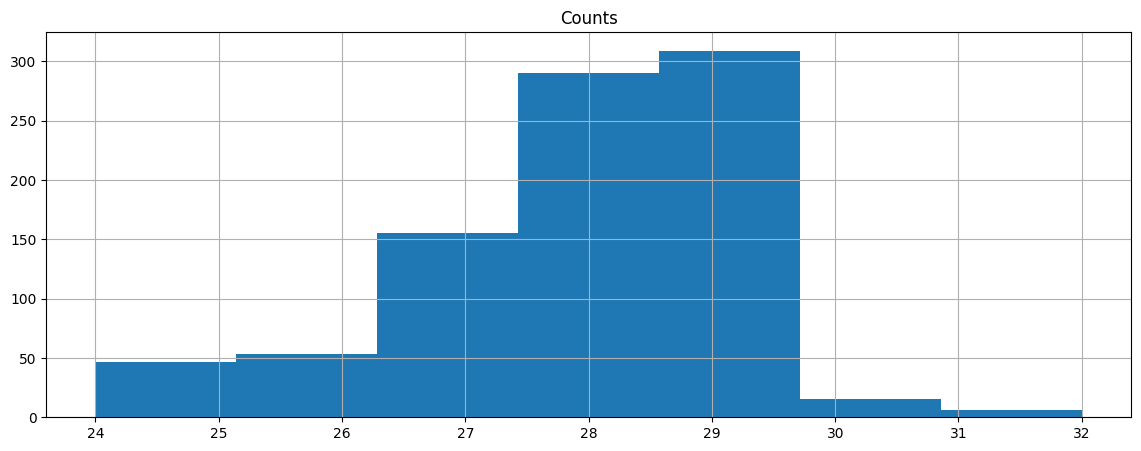

In [102]:
counts = [v.shape[0] for v in ev_x]
print(len(counts))
print(max(counts))
pd.DataFrame(counts, columns=['Counts']).hist(figsize=(14, 5), bins=7, )

In [103]:
data_x = ev_x + nf_x
data_y = ev_y + nf_y

# timestep_len = max(len(seq) for seq in data_x) # Determine the maximum sequence length
timestep_len = 24
data_x_pre = sequence.pad_sequences(data_x, maxlen=timestep_len, dtype='float64', padding='pre', truncating='pre')
data_y_pre = sequence.pad_sequences(data_y, maxlen=timestep_len, dtype='float64', padding='pre', truncating='pre')
data_x_post = sequence.pad_sequences(data_x, maxlen=timestep_len, dtype='float64', padding='post', truncating='post')
data_y_post = sequence.pad_sequences(data_y, maxlen=timestep_len, dtype='float64', padding='post', truncating='post')
# print(data_y_pre[0])
# print(data_y_post[0])
data_x = np.concatenate((data_x_pre, data_x_post), axis=0)
data_y = np.concatenate((data_y_pre, data_y_post), axis=0)

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.25, random_state=42)
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


x_train (4383, 24, 14)
x_test (1461, 24, 14)
y_train (4383, 24, 3)
y_test (1461, 24, 3)


In [104]:
def plot_training_history(history):
    # Extract the accuracy and loss from the history object
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [105]:
def LSTM_Model(features, targets, timesteps):
  targets = int(targets)
  print(features, targets, timesteps)
  model = Sequential()
  # model.add(layers.Masking(mask_value=0, input_shape=(timesteps, features)))
  # model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(timesteps, features)))
  # model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.LSTM(128, return_sequences=True, input_shape=(timesteps, features)))
  model.add(layers.TimeDistributed(layers.Dense(targets, activation='softmax')))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
  model.summary()
  return model

# def LSTM_Model(features, targets, timesteps):
#   model = Sequential()
#   model.add(layers.Masking(mask_value=0, input_shape=(timesteps, features)))
#   model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
#   model.add(layers.MaxPooling1D(pool_size=2))
#   model.add(layers.LSTM(256, return_sequences=False))
#   model.add(layers.Dense(128))
#   model.add(layers.Dense(timesteps * targets))
#   model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#   model.summary()
#   return model

In [106]:
lstm_model = LSTM_Model(x_train[0].shape[1], y_train[0].shape[1], timestep_len)


14 3 24


C:\Users\Dario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 24, 3)          │           387 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,603 (287.51 KB)

 Trainable params: 73,603 (287.51 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
lstm_train = lstm_model.fit(x_train, y_train, shuffle=True, epochs=250, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7614 - loss: 0.1259 - val_accuracy: 0.7517 - val_loss: 0.1285
Epoch 2/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7576 - loss: 0.1268 - val_accuracy: 0.7517 - val_loss: 0.1286
Epoch 3/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7538 - loss: 0.1270 - val_accuracy: 0.7517 - val_loss: 0.1290
Epoch 4/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7652 - loss: 0.1215 - val_accuracy: 0.7517 - val_loss: 0.1268
Epoch 5/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7565 - loss: 0.1232 - val_accuracy: 0.7517 - val_loss: 0.1272
Epoch 6/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7600 - loss: 0.1229 - val_accuracy: 0.7517 - val_loss: 0.1241
Epoch 7/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7612 - loss: 0.1209 - val_accuracy: 0.7516 - val_loss: 0.1223
Epoch 8/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7616 - loss: 0.1179 - 

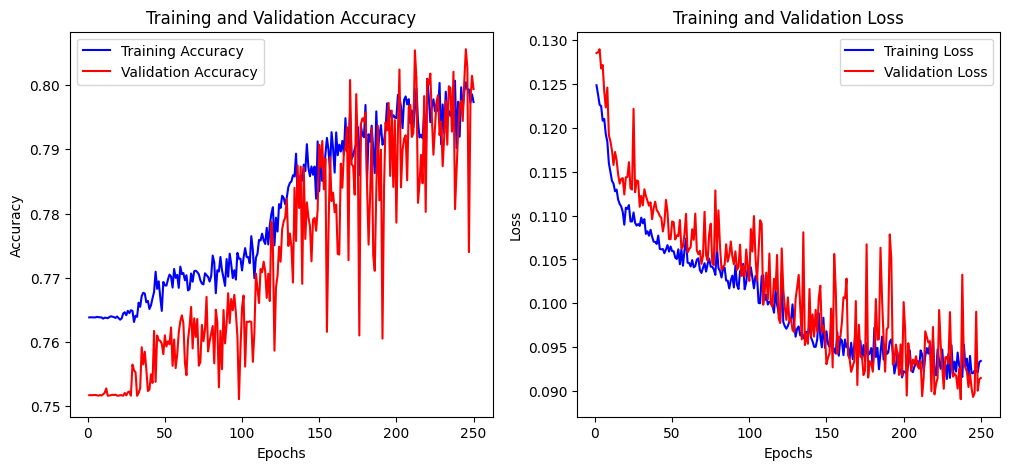

In [109]:
plot_training_history(lstm_train.history)


In [122]:
i = 9
test = x_test[i].reshape(1, 24, 14)
print(test)
print(y_test[i])
print(lstm_model(test))

[[[ 6.46000000e+01  1.00000000e+00  1.86000000e+00  9.99000000e+01
    1.00000000e+00  1.00000000e+00 -2.76152669e+01 -6.60544870e+01
    6.00000000e-01  4.70000000e-01  1.00000000e+00  2.65000000e+02
    9.99300000e+01  1.02200000e+03]
  [ 7.31000000e+01  1.00000000e+00  1.98000000e+00  9.99000000e+01
    1.00000000e+00  1.00000000e+00 -2.76155473e+01 -6.60543532e+01
    6.00000000e-01  5.00000000e-01  6.00000000e+00  2.65000000e+02
    9.99300000e+01  1.02800000e+03]
  [ 7.98000000e+01  1.00000000e+00  1.72000000e+00  9.99000000e+01
    1.00000000e+00  1.00000000e+00 -2.76157753e+01 -6.60542612e+01
    7.00000000e-01  4.28000000e-01  6.00000000e+00  2.65000000e+02
    9.99300000e+01  9.41000000e+02]
  [ 8.87000000e+01  1.00000000e+00  2.02000000e+00  9.99000000e+01
    1.00000000e+00  1.00000000e+00 -2.76160927e+01 -6.60542072e+01
    7.00000000e-01  5.01000000e-01  6.00000000e+00  2.65000000e+02
    9.99300000e+01  1.05900000e+03]
  [ 9.63000000e+01  1.00000000e+00  1.86000000e+00  